In [12]:
!pip install nixtla

In [13]:
!pip install yfinance

In [14]:
!pip install datasetsforecast

In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from nixtla import NixtlaClient

In [16]:
nixtla_client = NixtlaClient(api_key='nixtla-tok-2WhMO3zBSmvCWqvVBaBAH31mEBTR6YdwLdEurcwldlkVsex1JoxxKPAYYGXjvkPQxp1Ud77q5qvfCw7y')

acmresearch = "ACMR"
start = "2018-01-01"
end = "2023-12-15"

data = yf.download(acmresearch, start=start, end=end)
data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])

data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True) 

[*********************100%%**********************]  1 of 1 completed


In [17]:
train_data = data[(data['Date'] >= '2018-01-01') & (data['Date'] <= '2022-12-31')]
test_data = data[(data['Date'] >= '2023-01-01') & (data['Date'] <= '2023-12-15')]

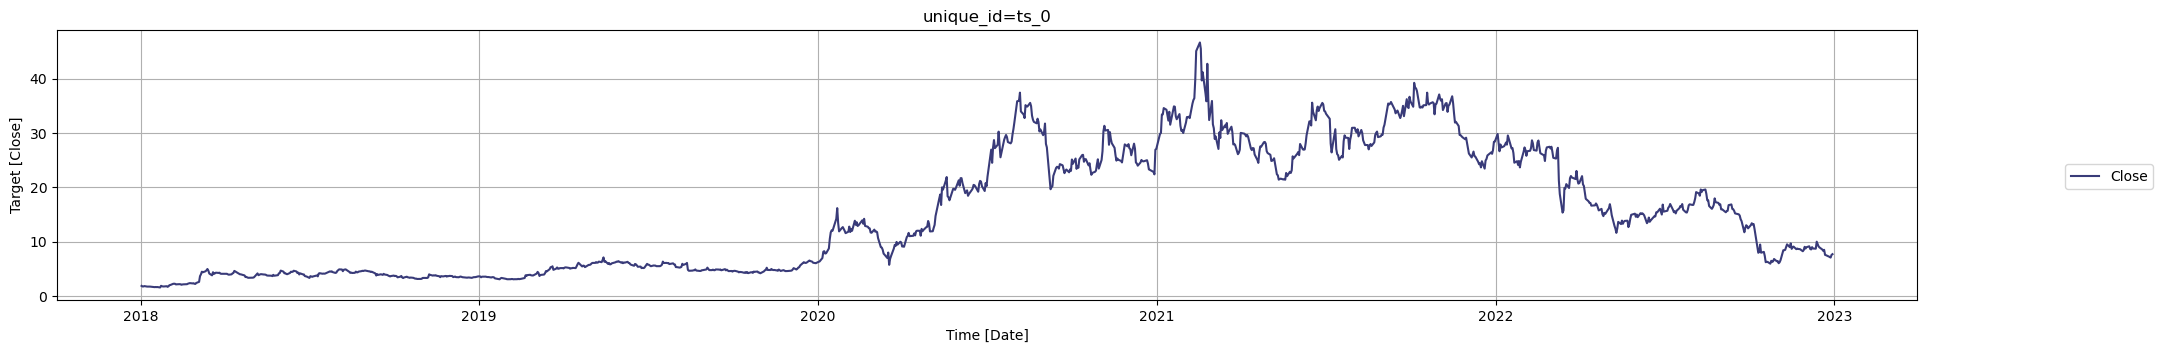

In [18]:
nixtla_client.plot(train_data, time_col='Date', target_col='Close')

In [19]:
data_forecast = nixtla_client.forecast(
    df=train_data,
    h=len(test_data),
    freq='B',
    level=[90],
    finetune_steps=10,
    model='timegpt-1-long-horizon',
    time_col='Date',
    target_col='Close'
)
data_forecast

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,Date,TimeGPT,TimeGPT-lo-90,TimeGPT-hi-90
0,2023-01-02,6.588001,5.409193,7.766808
1,2023-01-03,6.623327,3.940909,9.305745
2,2023-01-04,6.598816,3.390802,9.806831
3,2023-01-05,6.736079,3.502565,9.969594
4,2023-01-06,6.923819,3.121794,10.725844
...,...,...,...,...
235,2023-11-27,7.643748,-3.514027,18.801522
236,2023-11-28,7.684083,-3.355459,18.723625
237,2023-11-29,7.759636,-5.680191,21.199463
238,2023-11-30,7.735620,-3.955343,19.426582


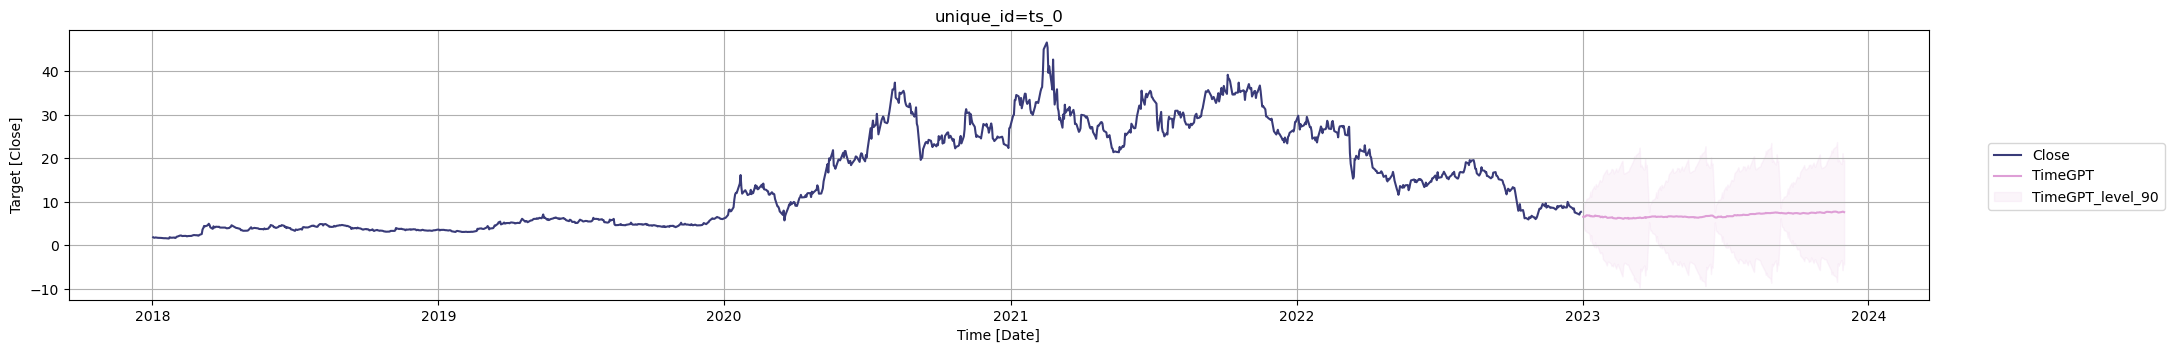

In [20]:
nixtla_client.plot(train_data, data_forecast, models=['TimeGPT'], level=[90], time_col='Date', target_col='Close')

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Anomaly Detector Endpoint...
INFO:nixtla.nixtla_client:Using the following exogenous variables: Open, High, Low, Adj Close, Volume


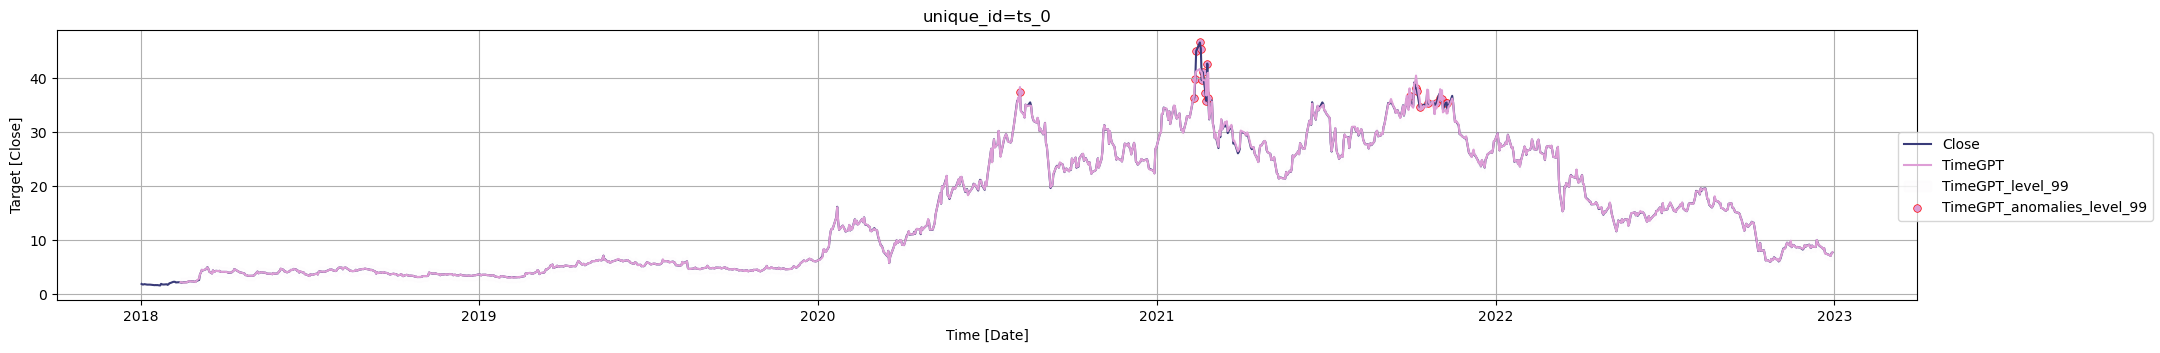

In [21]:
anomalies = nixtla_client.detect_anomalies(train_data, time_col='Date', target_col='Close', freq='B')
nixtla_client.plot(train_data, anomalies, time_col='Date', target_col='Close', plot_anomalies=True)

In [22]:
# Debugging: print the first few rows of data_forecast
print("Forecast data:")
print(data_forecast.head())

# Calculate metrics
rmse = mean_squared_error(test_data['Close'], data_forecast['TimeGPT'], squared=False)
mae = mean_absolute_error(test_data['Close'], data_forecast['TimeGPT'])

# Check for NaN values in data_forecast
if data_forecast['TimeGPT'].isnull().any():
    print("NaN values found in the forecast data")

# Replace zero values in test_data['Close'] with NaN
test_data_non_zero = test_data.copy()
test_data_non_zero['Close'].replace(0, np.nan, inplace=True)

# Drop rows with NaN values resulting from replacement
test_data_non_zero.dropna(subset=['Close'], inplace=True)

# Ensure that the Date column is the same format
data_forecast['Date'] = pd.to_datetime(data_forecast['Date'])
test_data_non_zero['Date'] = pd.to_datetime(test_data_non_zero['Date'])

# Print the first few rows of test_data_non_zero
print("Test data non-zero:")
print(test_data_non_zero.head())

# Align forecasts with the modified test data
aligned_forecast = data_forecast[data_forecast['Date'].isin(test_data_non_zero['Date'])].copy()

# Debugging: print the first few rows of aligned_forecast
print("Aligned forecast data before setting index:")
print(aligned_forecast.head())

# Ensure the indices match
test_data_non_zero.set_index('Date', inplace=True)
aligned_forecast.set_index('Date', inplace=True)

# Debugging: print the first few rows of aligned_forecast after setting index
print("Aligned forecast data after setting index:")
print(aligned_forecast.head())

# Check again for NaN values in the aligned forecast
if aligned_forecast['TimeGPT'].isnull().any():
    print("NaN values found in the aligned forecast data")

# Remove NaN values from aligned_forecast
aligned_forecast.dropna(subset=['TimeGPT'], inplace=True)

# Recalculate MAPE only for the dates that are present in both test_data_non_zero and aligned_forecast
common_dates = test_data_non_zero.index.intersection(aligned_forecast.index)
test_data_non_zero_common = test_data_non_zero.loc[common_dates]
aligned_forecast_common = aligned_forecast.loc[common_dates]

# Debugging: print the first few rows of the common data
print("Common test data:")
print(test_data_non_zero_common.head())
print("Common forecast data:")
print(aligned_forecast_common.head())

# Calculate MAPE
mape = np.mean(np.abs((test_data_non_zero_common['Close'].values - aligned_forecast_common['TimeGPT'].values) / test_data_non_zero_common['Close'].values)) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')


Forecast data:
         Date   TimeGPT  TimeGPT-lo-90  TimeGPT-hi-90
0  2023-01-02  6.588001       5.409193       7.766808
1  2023-01-03  6.623327       3.940909       9.305745
2  2023-01-04  6.598816       3.390802       9.806831
3  2023-01-05  6.736079       3.502565       9.969594
4  2023-01-06  6.923819       3.121794      10.725844
Test data non-zero:
           Date  Open   High    Low  Close  Adj Close   Volume
1259 2023-01-03  9.79  10.50  9.350   9.60       9.60  3634700
1260 2023-01-04  9.90  10.09  9.350   9.77       9.77  2231700
1261 2023-01-05  9.65   9.85  9.480   9.48       9.48  1798100
1262 2023-01-06  9.63   9.74  9.370   9.55       9.55   678100
1263 2023-01-09  9.85  10.32  9.737   9.97       9.97  1596100
Aligned forecast data before setting index:
        Date   TimeGPT  TimeGPT-lo-90  TimeGPT-hi-90
1 2023-01-03  6.623327       3.940909       9.305745
2 2023-01-04  6.598816       3.390802       9.806831
3 2023-01-05  6.736079       3.502565       9.969594
4 2023-

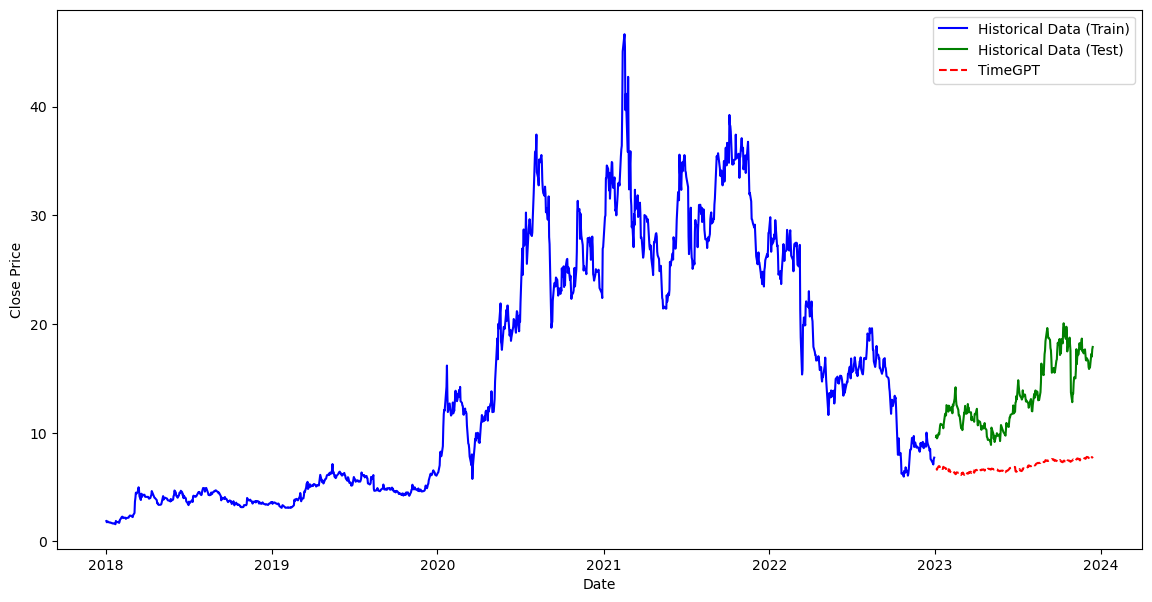

In [23]:
import matplotlib.pyplot as plt

# Визуализация на историческите данни и прогнозата
plt.figure(figsize=(14, 7))
plt.plot(train_data['Date'], train_data['Close'], label='Historical Data (Train)', color='blue')
plt.plot(test_data['Date'], test_data['Close'], label='Historical Data (Test)', color='green')
plt.plot(test_data['Date'], data_forecast['TimeGPT'], label='TimeGPT', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [24]:
highest_forecast_price = data_forecast['TimeGPT'].max()
lowest_forecast_price = data_forecast['TimeGPT'].min()

highest_forecast_date = data.loc[data_forecast['TimeGPT'].idxmax()]['Date']
lowest_forecast_date = data.loc[data_forecast['TimeGPT'].idxmin()]['Date']

print(f"Highest forecasted price: {highest_forecast_price} on {highest_forecast_date}")
print(f"Lowest forecasted price: {lowest_forecast_price} on {lowest_forecast_date}")

Highest forecasted price: 7.77447509765625 on 2018-11-29 00:00:00
Lowest forecasted price: 6.11234712600708 on 2018-02-26 00:00:00
